In [3]:
import os
import json
import re

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyproj as proj
from datetime import datetime
import pandas as pd
from netCDF4 import Dataset  # pylint:disable=no-name-in-module
from shapely.geometry import Point
import vega_datasets
import altair as alt


# import sys
from datetime import datetime
from glob import glob

import cartopy

sf_type = 1
marker_size = 1

In [3]:
# print(vega_datasets.data.world_110m.url)
# countries = alt.topo_feature(vega_datasets.data.world_110m.url, feature="land")

# alt.Chart(countries).mark_geoshape(
#     fill='lightgray',
#     stroke='white'
# ).project('stereographic', center=[0,90], clipAngle=40).properties(
#     width=500,
#     height=300
# )
# print(vega_datasets.data.us_10m.url)

In [4]:
timedata_si = pd.read_csv(
    "/home/jgnq4/Documents/eocis/seaice_dash_test/processed_files/time_series_data.csv", index_col=0
).sort_values("code")

max_v_si = np.round(timedata_si["thickness"].abs().max(axis=None) + 0.05, 1)
timedata_si.head(12)

,year,season_year,month,season_month,region,period,thickness
code,,,,,,,
201011,2010,2010,November,1,Arctic,2010/11,1.346105
201012,2010,2010,December,2,Arctic,2010/12,1.406308
201101,2011,2010,January,3,Arctic,2011/01,1.602596
201102,2011,2010,February,4,Arctic,2011/02,1.792676
201103,2011,2010,March,5,Arctic,2011/03,1.969767
201104,2011,2010,April,6,Arctic,2011/04,2.043077
201110,2011,2011,October,0,Arctic,2011/10,1.065559
201111,2011,2011,November,1,Arctic,2011/11,1.202023
201112,2011,2011,December,2,Arctic,2011/12,1.324390


In [ ]:
year_binding = alt.binding_select(options=timedata_si["season_year"].unique(), name="Season year")
year_select = alt.selection_point(bind=year_binding, fields=["season_year"])

thickness_si_chart = (
    alt.Chart(timedata_si, title="Mean sea ice thickness per year")
    .mark_line()
    .encode(
        alt.X(
            "month:N",
            title="Time Period",
            scale=alt.Scale(
                domain=["October", "November", "December", "January", "February", "March", "April"]
            ),
        ),
        alt.Y(
            "thickness:Q",
            title="Mean thickness (m)",
        ),
        alt.Color("season_year:N").legend(title="Season year"),
        opacity=alt.condition(year_select, alt.value(1), alt.value(0.05)),
    )
    .properties(width=900, height=400)
)

points = thickness_si_chart.mark_point().encode(tooltip=["thickness", "year", "month"])

jchart = alt.JupyterChart((thickness_si_chart + points).add_params(year_select))
jchart

dict_keys(['config', 'layer', 'data', 'height', 'params', 'width', '$schema', 'datasets'])

In [12]:
jchart.spec.pop("datasets")
jchart.spec

{'config': {'view': {'continuousWidth': 300, 'continuousHeight': 300}},
 'layer': [{'mark': {'type': 'line'},
   'encoding': {'color': {'field': 'season_year',
     'legend': {'title': 'Season year'},
     'type': 'nominal'},
    'opacity': {'condition': {'param': 'param_4', 'value': 1}, 'value': 0.05},
    'x': {'field': 'month',
     'scale': {'domain': ['October',
       'November',
       'December',
       'January',
       'February',
       'March',
       'April']},
     'title': 'Time Period',
     'type': 'nominal'},
    'y': {'field': 'thickness',
     'title': 'Mean thickness (m)',
     'type': 'quantitative'}},
   'name': 'view_4',
   'title': 'Mean sea ice thickness per year'},
  {'mark': {'type': 'point'},
   'encoding': {'color': {'field': 'season_year',
     'legend': {'title': 'Season year'},
     'type': 'nominal'},
    'opacity': {'condition': {'param': 'param_4', 'value': 1}, 'value': 0.05},
    'tooltip': [{'field': 'thickness', 'type': 'quantitative'},
     {'fie

In [10]:
file_name = "/home/jgnq4/Documents/eocis/seaice_dash_test/data_files/EOCIS-SEAICE-L3C-SITHICK-CS2-5KM-201011-fv1.0.nc"
nc = Dataset(file_name)
x_values = nc["xc"][:].data
y_values = nc["yc"][:
    ].data
thickness = nc["sea_ice_thickness"][:].data[0, :, :]

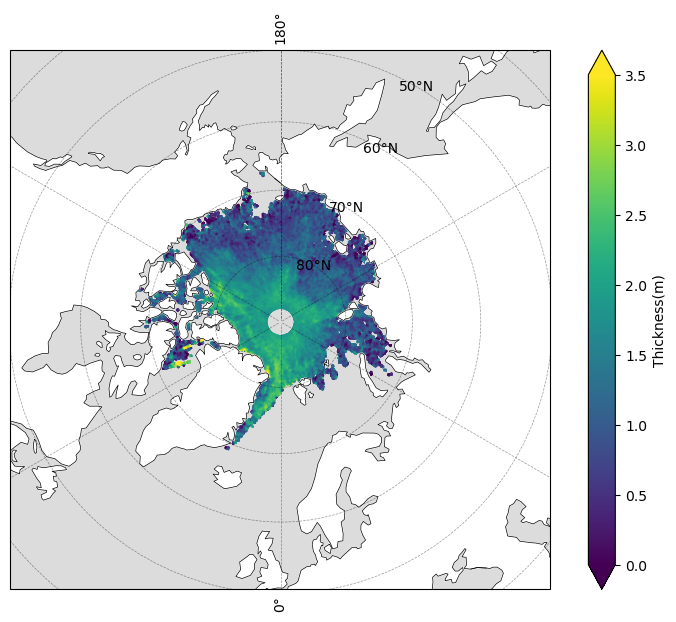

In [20]:
def plot_arco_thickness(x, y, values):
    crs_new = ccrs.NorthPolarStereo(central_longitude=0)

    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(facecolor="gainsboro", projection=crs_new)

    ax.coastlines(resolution="110m", linewidth=0.5)

    gl = ax.gridlines(draw_labels=True, color="black", alpha=0.4, linestyle="dashed", linewidth=0.5)
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    gl.ylabel_style = {
        "color": "black",
    }

    cs = ax.pcolormesh(
        x,
        y,
        values,
        vmax=3.5,
        vmin=0,
        cmap="viridis",
        transform=ccrs.Stereographic(
            central_latitude=90, central_longitude=-45, true_scale_latitude=70
        ),
        shading="gouraud",
    )
    ax.add_feature(cartopy.feature.LAND, color="white", zorder=1)
    fig.colorbar(cs, ax=ax, label="Thickness(m)", extend="both")

    return fig

_ = plot_arco_thickness(x_values, y_values, thickness)
